In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
# Step 1: Create a grid of points in the domain
def create_grid(num_points):
    x = torch.linspace(-1, 1, num_points)
    y = torch.linspace(-1, 1, num_points)
    x_grid, y_grid = np.meshgrid(x, y)
    x_grid = x_grid.flatten()
    y_grid = y_grid.flatten()
    return x_grid, y_grid

# Step 2: Randomly select points from the grid
def select_random_points(x_grid, y_grid, num_samples):
    indices = np.random.choice(len(x_grid), num_samples, replace=False)
    selected_x = x_grid[indices]
    selected_y = y_grid[indices]
    return selected_x, selected_y

def f2(f_exact ,f_pred):
    
    #f_pred =output
    r = (f_pred - f_exact)
    return torch.abs(r)
def adaptive_collocation_points(x, y,output,f_exact, k=1.0):
    
    f_pred = laplacien(output , x,y)
    residuals = f2(f_exact, f_pred.squeeze())
    
    p = residuals**k / torch.sum(residuals**k)

    
    indices = torch.multinomial(p.flatten(), num_samples=p.numel(), replacement=True)
    x_new = x.flatten()[indices].unsqueeze(1)
    y_new = y.flatten()[indices].unsqueeze(1)

    return x_new, y_new

def adaptive_collocation_points(x, y, output, f_exact, k=1.0, num_new_samples=100):
    """
    Adaptive sampling to generate new collocation points focused on high-residual areas.
    """
    f_pred = laplacien(output, x, y)
    residuals = f2(f_exact, f_pred.squeeze())
    
    # Add epsilon to residuals to avoid division by zero and normalize
    residuals = residuals + 1e-8
    p = (residuals**k) / (torch.sum(residuals**k) + 1e-8)  # Avoid sum zero issues
    
    # Limit the number of adaptive samples
    indices = torch.multinomial(p.flatten(), num_samples=num_new_samples, replacement=True)
    x_new = x.flatten()[indices].unsqueeze(1)
    y_new = y.flatten()[indices].unsqueeze(1)
    
    return x_new, y_new

def laplacien(u , x , y):

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True , retain_graph=True ,allow_unused=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True , retain_graph=True,allow_unused=True)[0]

    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True , retain_graph=True,allow_unused=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True, retain_graph=True,allow_unused=True)[0]

    

    return u_xx + u_yy
def wave_equation(u ,x,y,t):
    
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True , retain_graph=True ,allow_unused=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True , retain_graph=True,allow_unused=True)[0]

    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True , retain_graph=True,allow_unused=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True, retain_graph=True,allow_unused=True)[0]
    
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True , retain_graph=True,allow_unused=True)[0]
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u_t), create_graph=True, retain_graph=True,allow_unused=True)[0]
    
    return u_xx + u_yy - u_tt

def criterion(u , x , y ,f):

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True , retain_graph=True ,allow_unused=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True , retain_graph=True,allow_unused=True)[0]

    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True , retain_graph=True,allow_unused=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True, retain_graph=True,allow_unused=True)[0]

    #f = torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) +torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2)

    return F.mse_loss((u_xx + u_yy).squeeze(), f)



In [3]:
import torch
import torch.nn as nn
import torch.fft

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to keep in x direction
        self.modes2 = modes2  # Number of Fourier modes to keep in y direction
        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        # Complex multiplication in Fourier space
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        
        # Compute Fourier coefficients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)
        
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, device=x.device, dtype=torch.cfloat)
        
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to spatial domain
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, in_channels, out_channels, width, modes1, modes2):
        super(FNO2d, self).__init__()
        
        self.width = width
        self.fc0 = nn.Linear(in_channels, self.width)

        self.conv0 = SpectralConv2d(self.width, self.width, modes1, modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, modes1, modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, modes1, modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, modes1, modes2)
        
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, out_channels)

    def forward(self, x):
        # Lift input to higher dimension
        x = self.fc0(x)
        x = x.reshape(1,x.shape[0], x.shape[1], x.shape[2])
        x = x.permute(0, 3, 1, 2)  # Rearrange to (batch, channels, x, y)

        # Apply Fourier layers
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = torch.relu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = torch.relu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = torch.relu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        # Back to (batch, x, y, channels) and apply final layers
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

# Example usage
modes1 = 12
modes2 = 12
width = 20
in_channels = 2  # Input field dimension
out_channels = 1  # Solution field dimension

model = FNO2d(in_channels, out_channels, width, modes1, modes2)


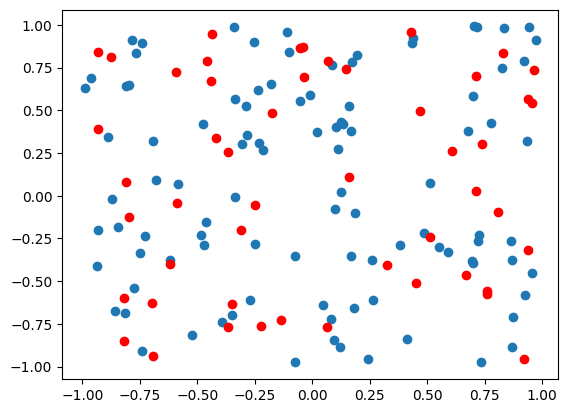

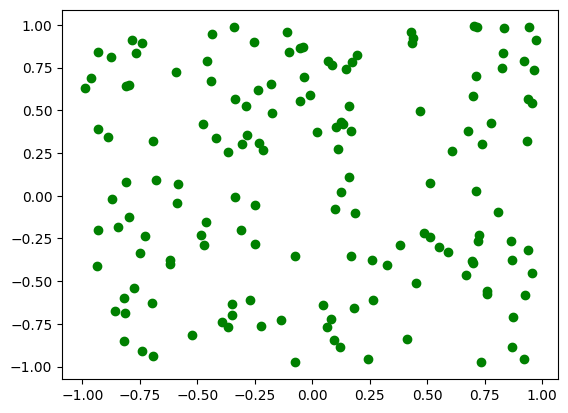

torch.Size([150, 150, 2])
False


c:\Users\mohammed\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
import torch

x = torch.rand(100 , requires_grad= True) * 2 - 1
y = torch.rand(100 , requires_grad= True) * 2 - 1



t1 = torch.rand(50 , requires_grad= True) * 2 - 1
t2 = torch.rand(50 , requires_grad= True) * 2 - 1
plt.scatter(x.cpu().detach().numpy() ,y.cpu().detach().numpy() )


plt.scatter(t1.detach().numpy() ,t2.detach().numpy() , color = 'red')
plt.show()
x_n = torch.cat([x.cpu(), t1], dim=0)
y_n = torch.cat([y.cpu(), t2], dim=0)

plt.scatter(x_n.detach().numpy() ,y_n.detach().numpy() , color = 'g')
plt.show()

x_n, y_n = torch.meshgrid(x_n, y_n)



x_n = x_n.unsqueeze(-1)
y_n = y_n.unsqueeze(-1)


inputs = torch.cat((x_n, y_n), dim=-1)

print(inputs.shape)
print(torch.cuda.is_available())

torch.Size([100, 100])
Epoch 1, Loss: 0.008364496752619743 mse :0.00013774412218481302


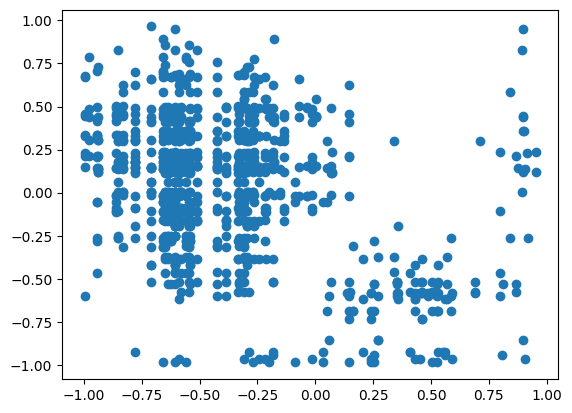

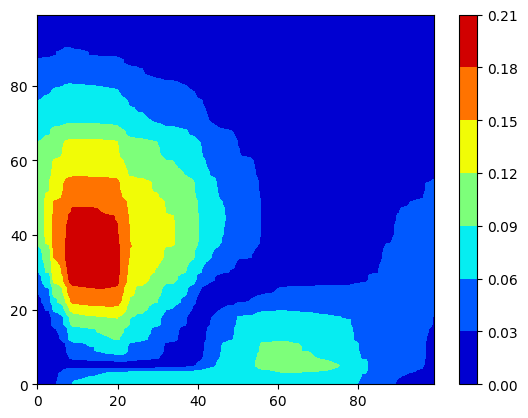

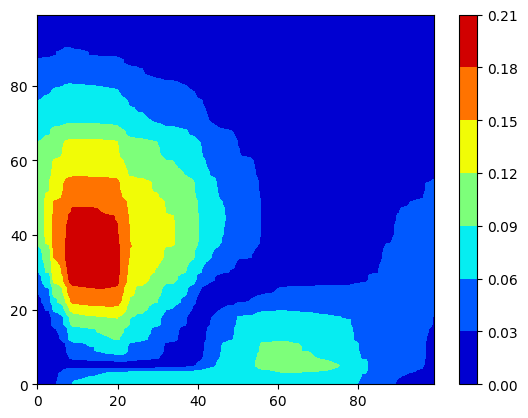

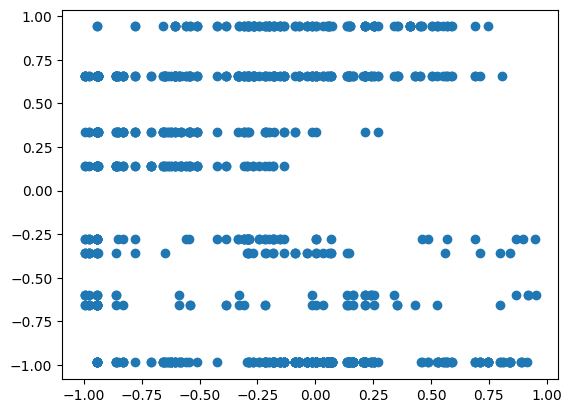

RuntimeError: shape '[110, 110]' is invalid for input of size 1331000

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb

#wandb.init(project="PINNs_Hard")

torch.random.seed()

class Net(nn.Module):
    def __init__(self,N_input ,N_output , N_Hidden ,N_layers):
        super(Net,self).__init__()
        activation = nn.Tanh()
        self.f1 = nn.Sequential(*[nn.Linear(N_input ,N_Hidden) , activation])
        self.f2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_Hidden , N_Hidden), activation]) for _ in range(N_layers)])
        self.f3 = nn.Sequential(*[nn.Linear(N_Hidden,N_output)])
    def forward(self , x) :
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        return x

net = Net(2,1,100,2)
#net = FNO2d(in_channels, out_channels, width, modes1, modes2).cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#wandb.watch(net)



#defining fixed points with a uniform distirbution
x = torch.rand(100 , requires_grad= True) * 2 - 1
y = torch.rand(100 , requires_grad= True) * 2 - 1
x = torch.sort(x)[0]
y = torch.sort(y)[0]
x, y = torch.meshgrid(x, y)
f = torch.zeros_like(x)
print(f.shape)
u_exact = x**2 - y**2
f = laplacien(u_exact , x , y).squeeze()
x = x.unsqueeze(-1)
y = y.unsqueeze(-1)
inputs = torch.cat((x, y), dim=-1)
A = (x**2- 1)+(1-y**2)
B = (y - 1)*(y + 1)*(x - 1)*(x + 1)


#defining fixed points with a uniform distirbution
x_adaptive = torch.rand(50 , requires_grad= True) * 2 - 1
y_adaptive = torch.rand(50 , requires_grad= True) * 2 - 1
x_adaptive = torch.sort(x_adaptive)[0]
y_adaptive = torch.sort(y_adaptive)[0]
x_adaptive, y_adaptive = torch.meshgrid(x_adaptive, y_adaptive)
x_adaptive = x_adaptive.unsqueeze(-1)
y_adaptive = y_adaptive.unsqueeze(-1)
adaptive_inputs = torch.cat((x_adaptive, y_adaptive), dim=-1)
A_a = (x_adaptive**2- 1)+(1-y_adaptive**2)
B_a = (y_adaptive - 1)*(y_adaptive + 1)*(x_adaptive - 1)*(x_adaptive + 1)


#training block
for epoch in range(100):
    optimizer.zero_grad()
    outputs = net(inputs)
    #print(outputs.shape)
    outputs = A + B*outputs
    loss = (criterion(outputs.squeeze(),x, y , f.squeeze()) )  #criterion(outputs,x, y , f)    criterion(adaptive_outputs,x_adaptive, y_adaptive , f)
    mse = F.mse_loss(outputs.squeeze(), u_exact.squeeze())
    #wandb.log({"loss": loss , "mse" : mse })
    if (epoch+1) %50 == 0:
        
        a,b = adaptive_collocation_points(x,y,outputs , f.squeeze() ,2 , 1000)
        #a,b = a.reshape(x.shape[0],x.shape[1])[:,0] ,b.reshape(x.shape[0],x.shape[1])[:,0]
        plt.scatter(a.cpu().detach().numpy() ,b.cpu().detach().numpy() )
        plt.show()
        
        
        f_pred = laplacien(outputs , x,y)
        r = f2(f, f_pred.squeeze()).reshape(x.shape[0] , x.shape[1])
        plt.contourf(r.T.cpu().detach().numpy().squeeze() , cmap = 'jet')
        plt.colorbar()
        plt.show()
        
        f_pred = laplacien(outputs , x,y)
        
        r = f2(f.squeeze(), f_pred.squeeze()) #.reshape(f_pred.shape[0] , f_pred .shape[1])
        plt.contourf(r.T.cpu().detach().numpy().squeeze() , cmap = 'jet')
        plt.colorbar()
        plt.show()
        
        
        #re adapting points   
        x_adaptive = torch.rand(10 , requires_grad= True) * 2 - 1
        y_adaptive = torch.rand(10 , requires_grad= True) * 2 - 1
        x_adaptive = torch.sort(x_adaptive)[0]
        y_adaptive = torch.sort(y_adaptive)[0]
        x_adaptive, y_adaptive = torch.meshgrid(x_adaptive, y_adaptive)
        x_adaptive = x_adaptive.unsqueeze(-1)
        y_adaptive = y_adaptive.unsqueeze(-1)
        adaptive_inputs = torch.cat((x_adaptive, y_adaptive), dim=-1)
        A_a = (x_adaptive**2- 1)+(1-y_adaptive**2)
        B_a = (y_adaptive - 1)*(y_adaptive + 1)*(x_adaptive - 1)*(x_adaptive + 1)
        adaptive_outputs = net(adaptive_inputs)
        adaptive_outputs = A_a + B_a*adaptive_outputs
        f_a = torch.zeros_like(x_adaptive)
        #x_adaptive, y_adaptive = torch.meshgrid(x_adaptive, y_adaptive)
        x_adaptive,y_adaptive = adaptive_collocation_points(x_adaptive,y_adaptive  ,adaptive_outputs, f_a.squeeze() , 1)
        

        x_adaptive = x_adaptive.reshape(10 , 10)
        x_adaptive = x_adaptive[: , 0]
        y_adaptive = y_adaptive.reshape(10 , 10)
        y_adaptive = y_adaptive[0 , :]
        x_adaptive = torch.sort(x_adaptive)[0]
        y_adaptive = torch.sort(y_adaptive)[0]
        
        #changes start here
        x = torch.cat([x[: ,0].squeeze(), x_adaptive], dim=0)
        y = torch.cat([y[: ,0].squeeze(), y_adaptive ], dim=0)
        x = torch.sort(x)[0]
        y = torch.sort(y)[0]
        x, y = torch.meshgrid(x, y)
        x = x.unsqueeze(-1)
        y = y.unsqueeze(-1)
        inputs = torch.cat((x, y), dim=-1)
        A = (x**2- 1)+(1-y**2)
        B = (y - 1)*(y + 1)*(x - 1)*(x + 1)
        #finish here
        f = torch.zeros_like(x)
        u_exact = x**2 - y**2
        
        

        x_adaptive, y_adaptive = torch.meshgrid(x_adaptive, y_adaptive)
        x_adaptive = x_adaptive.unsqueeze(-1)
        y_adaptive = y_adaptive.unsqueeze(-1)
        adaptive_inputs = torch.cat((x_adaptive, y_adaptive), dim=-1).squeeze()

        A_a = (x_adaptive**2- 1)+(1-y_adaptive**2)
        B_a = (y_adaptive - 1)*(y_adaptive + 1)*(x_adaptive - 1)*(x_adaptive + 1)





    #print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    loss.backward(retain_graph=True)
    optimizer.step()
    if epoch%100 == 0 :
        print(f'Epoch {epoch+1}, Loss: {loss.item()} mse :{mse}')


prediction = net(inputs)
print(inputs.shape)
prediction = A + B*prediction
print(prediction.shape)
prediction = prediction.cpu().detach().numpy().squeeze()

import matplotlib.pyplot as plt
plt.contourf(x.cpu().detach().numpy().squeeze(), y.cpu().detach().numpy().squeeze() , prediction , cmap = 'jet')
plt.colorbar()
plt.show()


plt.contourf(x.cpu().detach().numpy().squeeze(), y.cpu().detach().numpy().squeeze() ,u_exact.cpu().detach().numpy().squeeze() , cmap = 'jet')
plt.colorbar()
plt.show()



torch.Size([100, 100])
Epoch 1, Loss: 2.7056467533111572, Los2s: 2.7056593894958496  ,  Loss3: 2.0044872760772705 mse :0.2283300757408142
Epoch 101, Loss: 0.012996380217373371, Los2s: 0.013677404262125492  ,  Loss3: 13.918807983398438 mse :4.393503665924072
Epoch 201, Loss: 0.00284871575422585, Los2s: 0.003250764450058341  ,  Loss3: 6.185679912567139 mse :1.6583919525146484
Epoch 301, Loss: 0.0015930598601698875, Los2s: 0.0017168577760457993  ,  Loss3: 4.34261417388916 mse :1.1575813293457031
Epoch 401, Loss: 0.000807968492154032, Los2s: 0.0008353542070835829  ,  Loss3: 3.4860942363739014 mse :0.8793255686759949
Epoch 501, Loss: 0.01604929380118847, Los2s: 0.0160696879029274  ,  Loss3: 2.9643077850341797 mse :0.6490947008132935
Epoch 601, Loss: 0.00020912112086080015, Los2s: 0.00021887071488890797  ,  Loss3: 2.5465097427368164 mse :0.4662283957004547
Epoch 701, Loss: 0.00011794015154009685, Los2s: 0.00012933390098623931  ,  Loss3: 2.3583953380584717 mse :0.3721837103366852
Epoch 801, L

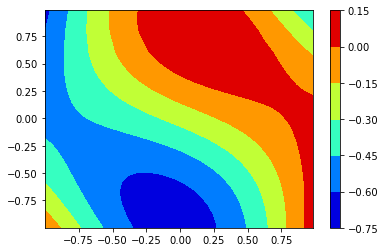

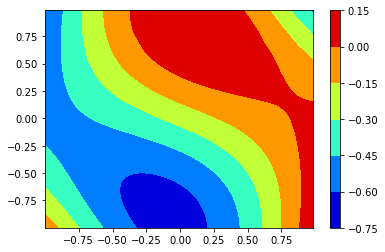

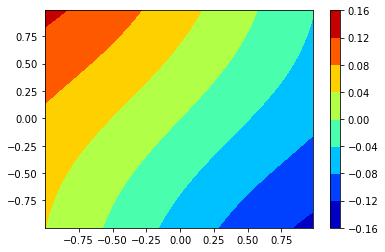

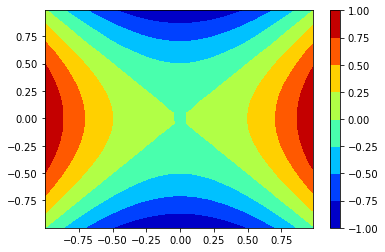

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb

#wandb.init(project="PINNs_Hard")

torch.random.seed()

class Net(nn.Module):
    def __init__(self,N_input ,N_output , N_Hidden ,N_layers):
        super(Net,self).__init__()
        activation = nn.Tanh()
        self.f1 = nn.Sequential(*[nn.Linear(N_input ,N_Hidden) , activation])
        self.f2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_Hidden , N_Hidden), activation]) for _ in range(N_layers)])
        self.f3 = nn.Sequential(*[nn.Linear(N_Hidden,N_output)])
    def forward(self , x) :
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        return x
class A(nn.Module):
    def __init__(self,N_input ,N_output , N_Hidden ,N_layers):
        super(A,self).__init__()
        activation = nn.Tanh()
        self.f1 = nn.Sequential(*[nn.Linear(N_input ,N_Hidden) , activation])
        self.f2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_Hidden , N_Hidden), activation]) for _ in range(N_layers)])
        self.f3 = nn.Sequential(*[nn.Linear(N_Hidden,N_output)])
    def forward(self , x) :
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        return x    

class B(nn.Module):
    def __init__(self,N_input ,N_output , N_Hidden ,N_layers):
        super(B,self).__init__()
        activation = nn.Tanh()
        self.f1 = nn.Sequential(*[nn.Linear(N_input ,N_Hidden) , activation])
        self.f2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_Hidden , N_Hidden), activation]) for _ in range(N_layers)])
        self.f3 = nn.Sequential(*[nn.Linear(N_Hidden,N_output)])
    def forward(self , x) :
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        return x

net = Net(2,1,100,2).cuda()
A_net = A(2,1,100,2).cuda()
B_net = B(2,1,100,2).cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

optimizer1 = torch.optim.Adam(A_net.parameters(), lr=0.01)

optimizer2 = torch.optim.Adam(B_net.parameters(), lr=0.01)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)

net.apply(init_weights)
A_net.apply(init_weights)
B_net.apply(init_weights)


#wandb.watch(net)



#defining fixed points with a uniform distirbution
x = torch.rand(100 , requires_grad= True).cuda() * 2 - 1
y = torch.rand(100 , requires_grad= True).cuda() * 2 - 1
x = torch.sort(x)[0]
y = torch.sort(y)[0]
x, y = torch.meshgrid(x, y)

print(f.shape)
u_exact = torch.sin(x) + torch.cos(y)
u_exact = x**2 - y**2
f = laplacien(u_exact , x , y).squeeze()
u1 , u2 , u3 , u4 = u_exact[:, 0], u_exact[:, -1], u_exact[0, :], u_exact[-1, :]
x = x.unsqueeze(-1)
y = y.unsqueeze(-1)
inputs = torch.cat((x, y), dim=-1)



#training block
for epoch in range(1000):
    optimizer.zero_grad()
    optimizer1.zero_grad()
    optimizer2.zero_grad()

    outputs = net(inputs)
    A = A_net(inputs)
    B = B_net(inputs)
    B = (y - 1)*(y + 1)*(x - 1)*(x + 1)
    outputs = A + B*outputs
    

    loss_pde = criterion(outputs.squeeze(), x, y, f.squeeze())
    loss_bc_B =criterion(outputs.squeeze(), x, y, f.squeeze()) + (F.mse_loss((B*outputs)[:, 0].squeeze(), torch.zeros_like(B[:, 0]).squeeze()) +
                 F.mse_loss((B*outputs)[:, -1].squeeze(), torch.zeros_like(B[:, -1]).squeeze()) +
                 F.mse_loss((B*outputs)[0, :].squeeze(), torch.zeros_like(B[0, :]).squeeze()) +
                 F.mse_loss((B*outputs)[-1, :].squeeze(), torch.zeros_like(B[-1, :]).squeeze()))
    loss_bc_A =  (F.mse_loss(A[:, 0].squeeze(), u1.squeeze()) +
                      F.mse_loss(A[:, -1].squeeze(), u2.squeeze()) +
                      F.mse_loss(A[0, :].squeeze(), u3.squeeze()) +
                      F.mse_loss(A[-1, :].squeeze(), u4.squeeze()))
    total_loss = loss_bc_B

    total_loss.backward(retain_graph=True)
    #optimizer.step()

    optimizer1.step()

    #optimizer2.step()
    

    if epoch%100 == 0 :
        outputs = A + B*outputs
        mse = F.mse_loss(outputs.squeeze(), u_exact.squeeze())
        print(f'Epoch {epoch+1}, Loss: {loss_pde.item()}, Los2s: {loss_bc_B.item()}  ,  Loss3: {loss_bc_A.item()} mse :{mse}')


prediction = net(inputs)
A = A_net(inputs)
B = B_net(inputs)
prediction = A + B*prediction
print(prediction.shape)
prediction = prediction.cpu().detach().numpy().squeeze()

import matplotlib.pyplot as plt
plt.contourf(x.cpu().detach().numpy().squeeze(), y.cpu().detach().numpy().squeeze() , prediction , cmap = 'jet')
plt.colorbar()
plt.show()
plt.contourf(x.cpu().detach().numpy().squeeze(), y.cpu().detach().numpy().squeeze() ,A.cpu().detach().numpy().squeeze() , cmap = 'jet')
plt.colorbar()
plt.show()
plt.contourf(x.cpu().detach().numpy().squeeze(), y.cpu().detach().numpy().squeeze() , B.cpu().detach().numpy().squeeze() , cmap = 'jet')
plt.colorbar()
plt.show()

plt.contourf(x.cpu().detach().numpy().squeeze(), y.cpu().detach().numpy().squeeze() ,u_exact.cpu().detach().numpy().squeeze() , cmap = 'jet')
plt.colorbar()
plt.show()



torch.Size([100, 100, 2])
torch.Size([100, 100, 1])
tensor(0.3432, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([100, 100, 1])


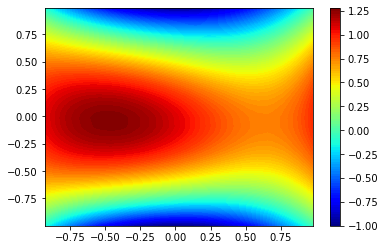

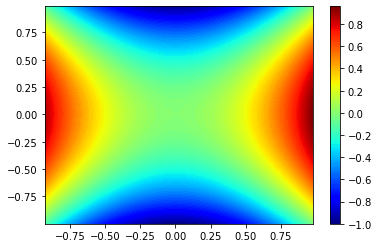

In [5]:
a = torch.rand(100 , requires_grad= True).cuda() * 2 - 1
b = torch.rand(100 , requires_grad= True).cuda() * 2 - 1

a = torch.sort(a)[0]
b = torch.sort(b)[0]

#a = torch.linspace(-1, 1, 50 , requires_grad= True)
#b = torch.linspace(-1, 1, 50 , requires_grad= True)
a,b = torch.meshgrid(a,b)
a = a.unsqueeze(-1)
b = b.unsqueeze(-1)
test_inputs = torch.cat((a, b), dim=-1)
print(test_inputs.shape)
test_outputs =  net(test_inputs)#torch.rand(100,100 , requires_grad= True).cuda().reshape(1,100,100,1)
print(test_outputs.shape)

A = (a**2- 1)+(1-b**2)
B = (b - 1)*(b + 1)*(a - 1)*(a + 1)
test_outputs = A + B*test_outputs
u_exact = a**2 - b**2
print(F.mse_loss(test_outputs.squeeze() , u_exact.squeeze() ))
print(test_outputs.shape)
plt.contourf(a.cpu().detach().numpy().squeeze(), b.cpu().detach().numpy().squeeze() , test_outputs.cpu().detach().numpy().squeeze() , cmap = 'jet' ,levels =100)
plt.colorbar()
plt.show()



plt.contourf(a.cpu().detach().numpy().squeeze(), b.cpu().detach().numpy().squeeze() ,u_exact.cpu().detach().numpy().squeeze() , cmap = 'jet',levels =100)
plt.colorbar()
plt.show()

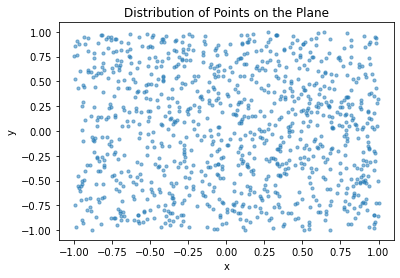

In [6]:
x = torch.rand(1000) * 2 - 1
y = torch.rand(1000) * 2 - 1

# Create scatter plot
plt.scatter(x.detach().numpy(), y.detach().numpy(), s=10, alpha=0.5)  # Adjust size and alpha as needed
plt.xlabel('x')
plt.ylabel('y')
plt.title('Distribution of Points on the Plane')
plt.show()

<AxesSubplot:ylabel='Count'>

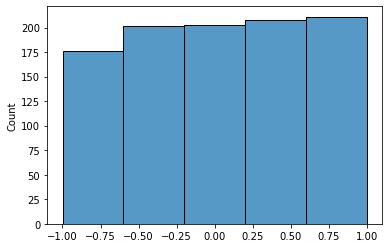

In [7]:
import seaborn as sns
x = torch.sort(x)[0]

sns.histplot(x.detach().numpy(), bins=5)

## soft constraint

In [54]:
def loss_boundary_1(u_pred , u_boundary):
    u_pred = u_pred.squeeze()
    u_pred_boundary = u_pred[: , 0]
    return F.mse_loss(u_pred_boundary , u_boundary.squeeze())

def loss_boundary_2(u_pred , u_boundary):
    
    u_pred = u_pred.squeeze()
    u_pred_boundary = u_pred[: , -1]
    return F.mse_loss(u_pred_boundary , u_boundary.squeeze())

def loss_boundary_3(u_pred , u_boundary):
    u_pred = u_pred.squeeze()
    u_pred_boundary = u_pred[0 , :]
    return F.mse_loss(u_pred_boundary , u_boundary.squeeze())

def loss_boundary_4(u_pred , u_boundary):
    u_pred = u_pred.squeeze()
    u_pred_boundary = u_pred[-1 , :]
    return F.mse_loss(u_pred_boundary , u_boundary.squeeze())



In [55]:



def train_soft(x,y, f ,u_exact , epochs = 500 , adaptive  = False ):
    
    inputs = torch.cat((x, y), dim=-1)
    
    boundary1  = u_exact[:,0]
    boundary2  = u_exact[:,-1]
    boundary3  = u_exact[0,:]
    boundary4  = u_exact[-1,:]
    boundary = [boundary1 , boundary2, boundary3 ,boundary4]
    net = Net(2,1,100,4).cuda()
    #net = FNO2d(in_channels, out_channels, width, 20, 20).cuda()
    #wandb.watch(net)
    weight0 = torch.tensor(1.0, requires_grad=True)
    weight1 = torch.tensor(1.0, requires_grad=True)
    weight2 = torch.tensor(1.0, requires_grad=True)
    weight3 = torch.tensor(1.0, requires_grad=True)
    weight4 = torch.tensor(1.0, requires_grad=True)

    optimizer = torch.optim.Adam([{'params':net.parameters()} ,{'params':[weight0,weight1, weight2,weight3, weight4]}], lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
    
    if adaptive : 
        x_adaptive = torch.rand(100 , requires_grad= True).cuda() * 2 - 1
        y_adaptive = torch.rand(100 , requires_grad= True).cuda() * 2 - 1
        x_adaptive = torch.sort(x_adaptive)[0]
        y_adaptive = torch.sort(y_adaptive)[0]
        x_adaptive, y_adaptive = torch.meshgrid(x_adaptive, y_adaptive)
        x_adaptive = x_adaptive.unsqueeze(-1)
        y_adaptive = y_adaptive.unsqueeze(-1)
        adaptive_inputs = torch.cat((x_adaptive, y_adaptive), dim=-1)
        

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(inputs)
        #f = torch.zeros_like(outputs)
        if not adaptive:
            optimizer.zero_grad()
            outputs = net(inputs).squeeze()
            loss_pde = criterion(outputs,x, y , f.squeeze())
            loss_bound1 , loss_bound2 , loss_bound3 , loss_bound4 = loss_boundary_1(outputs , boundary[0]) , loss_boundary_1(outputs , boundary[0]) , loss_boundary_3(outputs , boundary[2]) ,loss_boundary_4(outputs , boundary[3])
            loss = ((loss_pde*torch.exp(-weight0) + loss_bound1*torch.exp(-weight1) +loss_bound2*torch.exp(-weight2)  + loss_bound3*torch.exp(-weight3) +loss_bound4*torch.exp(-weight4))/5 + torch.abs(weight0)**2 + torch.abs(weight1)**2 + torch.abs(weight2)**2 + torch.abs(weight3)**2 + torch.abs(weight4)**2)*0.5
            mse = F.mse_loss(outputs.squeeze(), u_exact.squeeze())
            if epoch > 10 :
                pass
                #wandb.log({"loss": loss , "mse" : mse , "loss PDE" : loss_pde , "loss_bound1" : loss_bound1 , "loss_bound2" : loss_bound2  ,"loss_boun31" : loss_bound3  ,"loss_bound4" : loss_bound4 })
            if epoch%100 == 0 :
                print(f'Epoch {epoch+1}, Loss: {loss.item()} , mse : {mse}')
            loss.backward(retain_graph=True)
            optimizer.step()
            scheduler.step()
        else:
            optimizer.zero_grad()
            adaptive_outputs = net(adaptive_inputs)
            outputs = net(inputs).squeeze()
            loss_pde = criterion(outputs,x, y , f)
            loss_bound1 , loss_bound2 , loss_bound3 , loss_bound4 = loss_boundary_1(outputs , boundary[0]) , loss_boundary_1(outputs , boundary[0]) , loss_boundary_3(outputs , boundary[2]) ,loss_boundary_4(outputs , boundary[3])
            loss = ((loss_pde*torch.exp(-weight0) + loss_bound1*torch.exp(-weight1) +loss_bound2*torch.exp(-weight2)  + loss_bound3*torch.exp(-weight3) +loss_bound4*torch.exp(-weight4))/5 + torch.abs(weight0)**2 + torch.abs(weight1)**2 + torch.abs(weight2)**2 + torch.abs(weight3)**2 + torch.abs(weight4)**2)*0.5
            mse = F.mse_loss(outputs.squeeze(), u_exact.squeeze())
            if epoch > 10 :
                pass
                #wandb.log({"loss": loss , "mse" : mse , "loss PDE" : loss_pde , "loss_bound1" : loss_bound1 , "loss_bound2" : loss_bound2  ,"loss_boun31" : loss_bound3  ,"loss_bound4" : loss_bound4 })
            if (epoch)%100 == 0 :
                print(f'Epoch {epoch+1}, Loss: {loss.item()} , mse : {mse}')
                
                
                x_adaptive = torch.rand(10 , requires_grad= True).cuda() * 2 - 1
                y_adaptive = torch.rand(10 , requires_grad= True).cuda() * 2 - 1
                x_adaptive = torch.sort(x_adaptive)[0]
                y_adaptive = torch.sort(y_adaptive)[0]
                x_adaptive, y_adaptive = torch.meshgrid(x_adaptive, y_adaptive)
                x_adaptive = x_adaptive.unsqueeze(-1)
                y_adaptive = y_adaptive.unsqueeze(-1)
                adaptive_inputs = torch.cat((x_adaptive, y_adaptive), dim=-1)
                adaptive_outputs = net(adaptive_inputs)
                #x_adaptive, y_adaptive = torch.meshgrid(x_adaptive, y_adaptive)
                x_adaptive,y_adaptive = adaptive_collocation_points(x,y ,outputs.squeeze(),f.squeeze() , 1)

                x_adaptive = x_adaptive.reshape(x.shape[0] , x.shape[1])
                x_adaptive = x_adaptive[: , 0]
                y_adaptive = y_adaptive.reshape(x.shape[0] , x.shape[1])
                y_adaptive = y_adaptive[0 , :]
                x_adaptive = torch.sort(x_adaptive)[0]
                y_adaptive = torch.sort(y_adaptive)[0]

                #changes start here
                x = torch.cat([x[: ,0].squeeze(), x_adaptive], dim=0)
                y = torch.cat([y[: ,0].squeeze(), y_adaptive ], dim=0)
                x = torch.sort(x)[0]
                y = torch.sort(y)[0]
                x, y = torch.meshgrid(x, y)
                x = x.unsqueeze(-1)
                y = y.unsqueeze(-1)
                inputs = torch.cat((x, y), dim=-1)
                u_exact = op(x,y)
                f = laplacien(u_exact , x , y).squeeze()
                boundary1  = u_exact[:,0]
                boundary2  = u_exact[:,-1]
                boundary3  = u_exact[0,:]
                boundary4  = u_exact[-1,:]
                boundary = [boundary1 , boundary2, boundary3 ,boundary4]
                
                """x_adaptive = torch.rand(100 , requires_grad= True).cuda() * 2 - 1
                y_adaptive = torch.rand(100 , requires_grad= True).cuda() * 2 - 1
                x_adaptive = torch.sort(x_adaptive)[0]
                y_adaptive = torch.sort(y_adaptive)[0]

                x_adaptive, y_adaptive = torch.meshgrid(x_adaptive, y_adaptive)
                x_adaptive,y_adaptive = adaptive_collocation_points(x_adaptive,y_adaptive,adaptive_outputs , 1)

                x_adaptive = x_adaptive.reshape(100 , 100)
                x_adaptive = x_adaptive[: , 0]
                y_adaptive = y_adaptive.reshape(100 , 100 )
                y_adaptive = y_adaptive[0 , :]
                x_adaptive = torch.sort(x_adaptive)[0]
                y_adaptive = torch.sort(y_adaptive)[0]

                x_adaptive, y_adaptive = torch.meshgrid(x_adaptive, y_adaptive)
                x_adaptive = x_adaptive.unsqueeze(-1)
                y_adaptive = y_adaptive.unsqueeze(-1)
                adaptive_inputs = torch.cat((x_adaptive, y_adaptive), dim=-1)"""
            loss.backward(retain_graph=True)
            optimizer.step()
            scheduler.step()
            
    prediction = net(inputs).squeeze()
    prediction = prediction.cpu().detach().numpy().reshape(prediction.shape[0] , prediction.shape[1])
    
    
    plt.contourf(x.cpu().detach().numpy().squeeze(), y.cpu().detach().numpy().squeeze() , prediction , cmap = 'jet')
    plt.colorbar()
    #wandb.log({"contourf_plot": wandb.Image(plt)})
    plt.show()
    
    
    return net



Epoch 1, Loss: 2.6529321670532227 , mse : 0.6197875738143921
Epoch 101, Loss: 0.1238662451505661 , mse : 0.0007768958457745612
Epoch 201, Loss: 0.0014814338646829128 , mse : 0.0009439644636586308
Epoch 301, Loss: 2.8376949558150955e-05 , mse : 2.8956290407222696e-05
Epoch 401, Loss: 0.0004419440811034292 , mse : 0.0005084873992018402
Epoch 501, Loss: 1.3321504411578644e-05 , mse : 1.5920277292025276e-05
Epoch 601, Loss: 7.78850335336756e-06 , mse : 2.3954155039973557e-05
Epoch 701, Loss: 5.615195732389111e-06 , mse : 3.611596912378445e-05
Epoch 801, Loss: 4.343422915553674e-06 , mse : 4.790357343154028e-05
Epoch 901, Loss: 3.5044402011408238e-06 , mse : 5.774981764261611e-05
Epoch 1001, Loss: 2.915770210165647e-06 , mse : 6.574249709956348e-05
Epoch 1101, Loss: 2.4865887553460198e-06 , mse : 7.220684346975759e-05
Epoch 1201, Loss: 2.1644991647917777e-06 , mse : 7.743380410829559e-05
Epoch 1301, Loss: 1.916737346618902e-06 , mse : 8.165674807969481e-05
Epoch 1401, Loss: 1.72201919212966

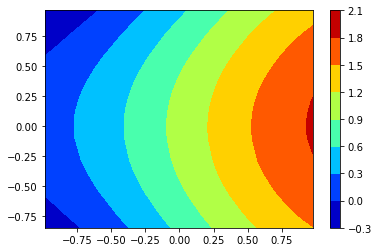

In [58]:
import wandb
operations = [
    lambda x, y: x**2 - y**2,
    lambda x, y: x**2 + y**2,
    lambda x, y: torch.sin(x) + torch.cos(y),
    lambda x, y: torch.exp(x) + torch.exp(y),
    lambda x, y: x * y + x**2 + y**2,
    lambda x, y: x**3 - y**3,
    lambda x, y: torch.log1p(x**2 + y**2),
    lambda x, y: torch.sin(x) * torch.cos(y),
    lambda x, y: (x**2 + y**2) * torch.sin(x + y),
    lambda x, y: torch.zeros_like(x),
]

x = torch.rand(50 , requires_grad= True).cuda() * 2 - 1
y = torch.rand(50 , requires_grad= True).cuda() * 2 - 1
x = torch.sort(x)[0]
y = torch.sort(y)[0]
x, y = torch.meshgrid(x, y)
f = torch.zeros_like(x)
u_exact = x**2 - y**2
x = x.unsqueeze(-1)
y = y.unsqueeze(-1)
inputs = torch.cat((x, y), dim=-1)
i = 0

for op in operations[2:3] : 
    #wandb.init(project="PINN_soft", name=f"u1_fix_fno" )
    i += 1
    u_exact = op(x,y)
    #u_exact.requires_grad_() = True
    f = laplacien(u_exact , x , y).squeeze()
    boundary1  = u_exact[:,0]
    boundary2  = u_exact[:,-1]
    boundary3  = u_exact[0,:]
    boundary4  = u_exact[-1,:]
    bound = [boundary1 , boundary2, boundary3 ,boundary4]
    net_fix = train_soft(x,y, f , u_exact , epochs = 2000 ,adaptive = False) 
    #net = train_soft(x,y, f , u_exact , epochs = 500  ,adaptive = True)
    


torch.Size([20, 20])
Epoch 1, Loss: 2.561339855194092 , mse : 0.16324514150619507
Epoch 101, Loss: 0.20362025499343872 , mse : 0.22967250645160675
Epoch 201, Loss: 0.03888591378927231 , mse : 0.14236582815647125
Epoch 301, Loss: 0.03518441691994667 , mse : 0.11780446767807007
Epoch 401, Loss: 0.01937885209918022 , mse : 0.06490673124790192


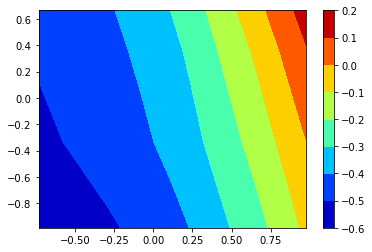

In [11]:
for op in operations[0:1] : 
    #wandb.init(project="PINN_soft", name=f"u1_adapt" )
    i += 1
    u_exact = op(x,y)
    #u_exact.requires_grad_() = True
    f = laplacien(u_exact , x , y).squeeze()
    print(f.shape)
    boundary1  = u_exact[:,0]
    boundary2  = u_exact[:,-1]
    boundary3  = u_exact[0,:]
    boundary4  = u_exact[-1,:]
    bound = [boundary1 , boundary2, boundary3 ,boundary4]
    net_adapt = train_soft(x,y, f , u_exact , epochs = 401  ,adaptive = True)

In [12]:
!export CUDA_LAUNCH_BLOCKING=1

torch.Size([100, 100, 2])
tensor(0.3801, device='cuda:0', grad_fn=<MseLossBackward0>)


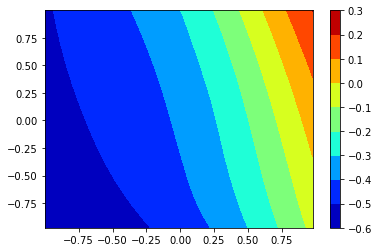

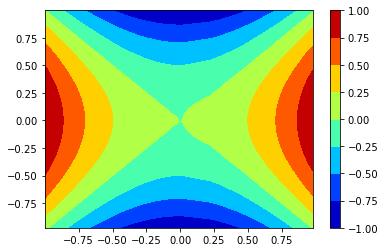

In [13]:
a = torch.rand(100 , requires_grad= True).cuda() * 2 - 1
b = torch.rand(100 , requires_grad= True).cuda() * 2 - 1

a = torch.sort(a)[0]
b = torch.sort(b)[0]

#a = torch.linspace(-1, 1, 50 , requires_grad= True)
#b = torch.linspace(-1, 1, 50 , requires_grad= True)
a,b = torch.meshgrid(a,b)
a = a.unsqueeze(-1)
b = b.unsqueeze(-1)
test_inputs = torch.cat((a, b), dim=-1)
print(test_inputs.shape)
test_outputs = net_adapt(test_inputs)
u_exact = op(a,b)

print(F.mse_loss(test_outputs , u_exact ))

plt.contourf(a.cpu().detach().numpy().squeeze(), b.cpu().detach().numpy().squeeze() , test_outputs.cpu().detach().numpy().squeeze() , cmap = 'jet')
plt.colorbar()
plt.show()



plt.contourf(a.cpu().detach().numpy().squeeze(), b.cpu().detach().numpy().squeeze() ,u_exact.cpu().detach().numpy().squeeze() , cmap = 'jet')
plt.colorbar()
plt.show()

In [14]:
import torch

def wave_equation(u ,x,t):
    
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True , retain_graph=True ,allow_unused=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True , retain_graph=True,allow_unused=True)[0]
    
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True , retain_graph=True,allow_unused=True)[0]
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u_t), create_graph=True, retain_graph=True,allow_unused=True)[0]
    
    return F.mse_loss(torch.zeros_like(u_xx).squeeze(), (u_xx - u_tt).squeeze())
modes1 , modes2 = 5 , 5
net = Net(2,1,100,2).cuda()
#net = FNO2d(in_channels, out_channels, width, modes1, modes2).cuda()

weight1 = torch.tensor(1.0, requires_grad=True)
weight2 = torch.tensor(1.0, requires_grad=True)
weight3 = torch.tensor(1.0, requires_grad=True)
weight4 = torch.tensor(1.0, requires_grad=True)

optimizer = torch.optim.Adam([{'params':net.parameters()} ,{'params':[weight1, weight2,weight3, weight4]}], lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

x = torch.linspace(-5 , 5 , 100 , requires_grad= True).cuda() #torch.rand(20 , requires_grad= True).cuda() * 2 - 1
t = torch.linspace(0 , 12 , 48, requires_grad= True).cuda()
x = torch.sort(x)[0]
u_init = torch.exp(-x**2)
ut_init = 2*x*u_init
ux_boundary = torch.zeros_like(t)
x,t = torch.meshgrid(x,t)

u_forward = torch.exp(-(x-t)**2)
u_backward = -torch.exp(-(x-2*torch.ones_like(x)*5 + t)**2)
u_real = u_forward  + u_backward

inputs = torch.cat([x.unsqueeze(-1) , t.unsqueeze(-1)] , dim = -1)
init_input = x

for epoch in range(3000):
    optimizer.zero_grad()
    outputs = net(inputs).squeeze()
    u_t = torch.autograd.grad(outputs, t, grad_outputs=torch.ones_like(outputs), create_graph=True , retain_graph=True,allow_unused=True)[0]
    
    #loss = ((wave_equation(outputs ,x,t)*torch.exp(-weight1) + F.mse_loss(outputs[-1,:].squeeze(),ux_boundary.squeeze())*torch.exp(-weight2) + F.mse_loss(outputs[:,0:1].squeeze(),u_init)*torch.exp(-weight3)+ F.mse_loss(u_t[:,0:1].squeeze(),ut_init)*torch.exp(-weight4))/4 + torch.abs(weight1)**2 + torch.abs(weight2)**2 + torch.abs(weight3)**2 + torch.abs(weight4)**2)*0.5
    loss = (wave_equation(outputs ,x,t) + F.mse_loss(outputs[-1,:].squeeze(),ux_boundary.squeeze()) + F.mse_loss(outputs[:,0:1].squeeze(),u_init)+ F.mse_loss(u_t[:,0:1].squeeze(),ut_init))/4
    mse = F.mse_loss(outputs.squeeze(), u_real.squeeze())
    if epoch %100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()} , mse : {mse}')
    if (epoch+1)%1000 == 0 :

        x_adaptive = torch.rand(20 , requires_grad= True).cuda() * 2 - 1
        t_new = torch.linspace(0 , 12 , 48, requires_grad= True).cuda()
        x_adaptive = torch.sort(x_adaptive)[0]
        x_adaptive, t_new = torch.meshgrid(x_adaptive, t_new)
        x_adaptive = x_adaptive.unsqueeze(-1)
        t_new = t_new.unsqueeze(-1)
        adaptive_inputs = torch.cat((x_adaptive, t_new), dim=-1)
        adaptive_outputs = net(adaptive_inputs)
        #x_adaptive, y_adaptive = torch.meshgrid(x_adaptive, y_adaptive)
        x_adaptive,_= adaptive_collocation_points(x_adaptive,t_new ,adaptive_outputs , 1)
        #plt.scatter(x_adaptive.cpu().detach().numpy() , t_new.cpu().detach().numpy())
        #plt.show()


        x_adaptive = x_adaptive.reshape(20 , 48)
        x_adaptive = x_adaptive[: , 0]
        x_adaptive = torch.sort(x_adaptive)[0]

        #changes start here
        x = torch.cat([x[: ,0].squeeze(), x_adaptive], dim=0)

        x = torch.sort(x)[0]
        u_init = torch.exp(-x**2)
        ut_init = 2*x*u_init
        ux_boundary = torch.zeros_like(t[0 ,:])
        x, t = torch.meshgrid(x, t[0 ,:])       
        inputs = torch.cat((x.unsqueeze(-1), t.unsqueeze(-1)), dim=-1)
        u_forward = torch.exp(-(x-t)**2)
        u_backward = -torch.exp(-(x-2*torch.ones_like(x)*5 + t)**2)
        u_real = u_forward  + u_backward

    
    loss.backward(retain_graph=True)
    optimizer.step()

print(f"The loss at the last itteration {loss}")
#print(f"the mse loss between the prediction and the actual solution {F.mse_loss(u_real , outputs.squeeze())}")
print(inputs.shape)


Epoch 1, Loss: 0.062097758054733276 , mse : 0.09654602408409119
Epoch 101, Loss: 0.0018472329247742891 , mse : 0.07868190854787827
Epoch 201, Loss: 0.0016852736007422209 , mse : 0.07927992194890976
Epoch 301, Loss: 0.001639912254177034 , mse : 0.07957665622234344
Epoch 401, Loss: 0.0016036613378673792 , mse : 0.08099299669265747
Epoch 501, Loss: 0.0015588555252179503 , mse : 0.0845034271478653
Epoch 601, Loss: 0.001488576061092317 , mse : 0.0877375453710556
Epoch 701, Loss: 0.0013568294234573841 , mse : 0.0923101007938385
Epoch 801, Loss: 0.0011706652585417032 , mse : 0.10040877014398575
Epoch 901, Loss: 0.0011192610254511237 , mse : 0.09413020312786102
Epoch 1001, Loss: 0.0012614389415830374 , mse : 0.09480199962854385
Epoch 1101, Loss: 0.0010686347959563136 , mse : 0.09203372895717621
Epoch 1201, Loss: 0.0010863988427445292 , mse : 0.053834445774555206
Epoch 1301, Loss: 0.0005236802389845252 , mse : 0.031146999448537827
Epoch 1401, Loss: 0.0012631741119548678 , mse : 0.01574791781604

the mse loss between the prediction and the actual solution 0.0003109275421593338


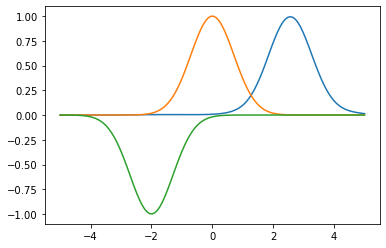

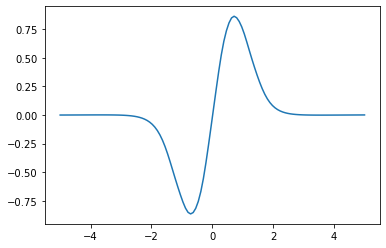

In [15]:
"""u_forward = torch.exp(-(x-t)**2)
u_backward = -torch.exp(-(x-2*torch.ones_like(x)*5 + t)**2)
u_real = u_forward  + u_backward"""
x = torch.linspace(-5 , 5 , 120 , requires_grad= True).cuda() #torch.rand(20 , requires_grad= True).cuda() * 2 - 1
t = torch.linspace(0 , 12 , 48, requires_grad= True).cuda()
x = torch.sort(x)[0]
u_init = torch.exp(-x**2)
ut_init = 2*x*u_init
ux_boundary = torch.zeros_like(t)
x,t = torch.meshgrid(x,t)

u_forward = torch.exp(-(x-t)**2)
u_backward = -torch.exp(-(x-2*torch.ones_like(x)*5 + t)**2)
u_real = u_forward  + u_backward
inputs = torch.cat([x.unsqueeze(-1) , t.unsqueeze(-1)] , dim = -1)
u_pred = net(inputs).squeeze()
u_t = torch.autograd.grad(u_pred, t, grad_outputs=torch.ones_like(u_pred), create_graph=True , retain_graph=True,allow_unused=True)[0]

print(f"the mse loss between the prediction and the actual solution {F.mse_loss(u_real , u_pred.squeeze())}")
plt.plot(x[: ,0].cpu().detach().numpy() ,u_pred[:,10].cpu().detach().numpy() )
plt.plot( x[: ,0].cpu().detach().numpy() ,u_init.cpu().detach().numpy() )
plt.plot( x[: ,47].cpu().detach().numpy() ,u_real[: , 47].cpu().detach().numpy() )
plt.show()



plt.show()
plt.plot( x[: ,0].cpu().detach().numpy(),u_t[: , 0].cpu().detach().numpy())
plt.show()

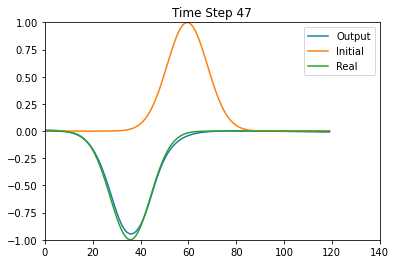

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set up the figure
fig, ax = plt.subplots()
line1, = ax.plot([], [], label='Output')  # Animated line for outputs
line2, = ax.plot([], [], label='Initial')  # Animated line for u_init
line3, = ax.plot([], [], label='Real')     # Animated line for u_real
ax.legend()

# Set axis limits if needed
ax.set_xlim(0, outputs.shape[0])  # Set based on data range
ax.set_ylim(-1, 1)  # Adjust based on expected value range

# Initialization function
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    return line1, line2, line3

# Update function
def update(i):
    x = np.arange(u_pred.shape[0])  # x-axis for plotting
    line1.set_data(x, u_pred[:, i].cpu().detach().numpy())
    line2.set_data(x, u_init.cpu().detach().numpy())
    line3.set_data(x, u_real[:, i].cpu().detach().numpy())
    ax.set_title(f"Time Step {i}")
    return line1, line2, line3

# Create the animation
ani = FuncAnimation(fig, update, frames=48, init_func=init, blit=True)

# Display the animation in Jupyter
HTML(ani.to_jshtml())


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the Decode model
class Decode(nn.Module):
    def __init__(self, input_shape):
        super(Decode, self).__init__()
        
        self.input_shape = input_shape
        self.layers = nn.Sequential(
            nn.Linear(self.input_shape, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Tanh(),
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, self.input_shape),
            nn.Tanh() 
        )

    def forward(self, x):
        return self.layers(x)

# Create synthetic data
x = torch.linspace(-5, 5, 100, requires_grad=True).cuda()
t = torch.linspace(0, 12, 48, requires_grad=True).cuda()
x, t = torch.meshgrid(x, t)

# Create u_real target data
u_forward = torch.exp(-(x - t)**2)
u_backward = -torch.exp(-(x - 2 * torch.ones_like(x) * 5 + t)**2)
u_real = u_forward + u_backward    
train = u_real.flatten().cuda()

# Initialize the model, optimizer, and loss function
model = Decode(train.shape[0]).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for i in range(5000):
    optimizer.zero_grad() 
    
    # Forward pass
    u_pred = model(train)
    loss = F.mse_loss(u_pred, train)  # Loss function
    
    # Print loss every 100 iterations
    if i % 100 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")
    
    # Backward pass and optimization step
    loss.backward(retain_graph=True)  # Remove `retain_graph=True` for efficiency
    optimizer.step()


Iteration 0, Loss: 0.13329733908176422
Iteration 100, Loss: 0.0001374434505123645
Iteration 200, Loss: 3.230391666875221e-05
Iteration 300, Loss: 1.4499545613944065e-05
Iteration 400, Loss: 8.185016667994205e-06
Iteration 500, Loss: 5.253760718915146e-06
Iteration 600, Loss: 3.6382843973115087e-06
Iteration 700, Loss: 2.6704103675001534e-06
Iteration 800, Loss: 2.0524132651189575e-06
Iteration 900, Loss: 1.6162900919880485e-06
Iteration 1000, Loss: 1.2928323940286646e-06
Iteration 1100, Loss: 1.0546757494012127e-06
Iteration 1200, Loss: 9.319997502643673e-07
Iteration 1300, Loss: 9.317617468695971e-07
Iteration 1400, Loss: 6.419805345103669e-07
Iteration 1500, Loss: 6.191408488120942e-07
Iteration 1600, Loss: 6.518686745948798e-07
Iteration 1700, Loss: 7.159524102462456e-07
Iteration 1800, Loss: 7.602382652294182e-07
Iteration 1900, Loss: 3.7931170027150074e-07
Iteration 2000, Loss: 2.950844759652682e-07
Iteration 2100, Loss: 2.153484274458606e-06
Iteration 2200, Loss: 5.57688849767146

In [1]:
import torch
import torch.nn as nn
import numpy as np
def integrate_function(model, sampler, domain, device='cpu'):
    """
    Approximates the integral of the model over the specified domain using sampling.

    Parameters:
    - model (torch.nn.Module): The neural network model representing the function to integrate.
    - sampler (callable): Function to generate sample points within the domain.
    - domain (dict): Specifications of the integration domain.
    - device (str): Device to perform computations on.

    Returns:
    - integral (torch.Tensor): Approximated integral value.
    """
    samples = sampler(domain['bounds'], domain['n_samples'], device)
    samples.requires_grad = True
    outputs = model(samples)
    integral = torch.mean(outputs) * domain['volume']
    return integral

# Example usage for 1D integration of sin(x) from 0 to pi
def sampler_1d(bounds, n_samples, device='cpu'):
    a, b = bounds
    x = torch.rand(n_samples, 1, device=device) * (b - a) + a
    return x

class SinModel(nn.Module):
    def forward(self, x):
        return torch.sin(x)
device = 'cuda'
model = SinModel().to(device)
domain = {'bounds': (0.0, torch.pi), 'n_samples': 100000, 'volume': torch.pi}
integral = integrate_function(model, sampler_1d, domain, device = 'cuda')
print(integral.item())  # Expected: ~2.0
print(-torch.cos(torch.tensor(np.pi)) + torch.cos(torch.tensor(0)))



1.9966391324996948
tensor(2.)


tensor(0.0427, device='cuda:0', grad_fn=<DotBackward0>)
tensor(0.4837, device='cuda:0', grad_fn=<DotBackward0>)
tensor(-0.0427, device='cuda:0', grad_fn=<DotBackward0>)
Epoch 0, Loss: 5.913328647613525


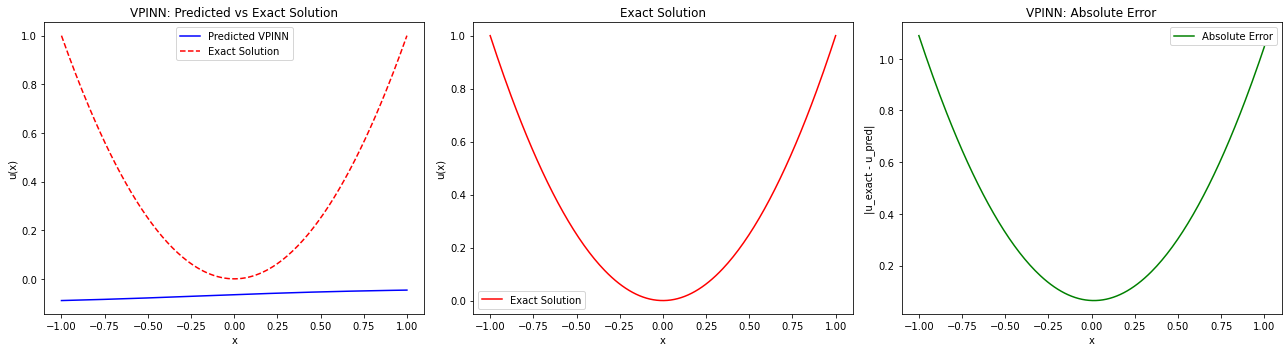

In [150]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define the neural network model
class Net(nn.Module):
    def __init__(self, N_input, N_output, N_Hidden, N_layers):
        super(Net, self).__init__()
        activation = nn.Tanh()
        self.f1 = nn.Sequential(nn.Linear(N_input, N_Hidden), activation)
        self.f2 = nn.Sequential(*[
            nn.Sequential(nn.Linear(N_Hidden, N_Hidden), activation) for _ in range(N_layers)
        ])
        self.f3 = nn.Sequential(nn.Linear(N_Hidden, N_output))
        
    def forward(self, x):
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        return x

# Define derivative function
def derivation(u, x, order=1):
    for _ in range(order):
        u = torch.autograd.grad(
            u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True, allow_unused=True
        )[0]
    return u

# Monte Carlo integration function
def monte_carlo_integrate(func, samples, volume):
    """
    Approximates the integral of a function using Monte Carlo integration.
    
    Parameters:
    - func (callable): Function to integrate. Should accept a tensor and return a tensor.
    - samples (torch.Tensor): Sample points with shape [N_samples, 1].
    - volume (float): Volume (length in 1D) of the integration domain.
    
    Returns:
    - integral (torch.Tensor): Approximated integral value.
    """
    return torch.mean(func(samples)) * volume

# Instantiate the model
device='cuda'
model = Net(1, 1, 100, 5).cuda()
#model.to(device='cuda')  # Change to 'cuda' if using GPU

# Define exact solution and source term
u_exact = lambda x: x**2
f_exact = lambda x: torch.full_like(x, 2.0)  # u''(x) = 2

# Define boundary points and exact boundary values
x_boundary = torch.tensor([[-1.0], [1.0]], requires_grad=True).cuda()
u_boundary_exact = torch.tensor([[1.0], [1.0]]).cuda()  # u(-1) = 1, u(1) = 1

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Define the volume (domain length)
volume = 2.0  # [-1,1] in 1D
x =  ( torch.rand(N_collocation, 1, requires_grad=True) * 2 - 1).cuda()  # x in [-1,1]
#x_collocation.cuda() #.to(device = 'cuda')

# Training loop
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    
    # Sample collocation points for Monte Carlo integration
    N_collocation = 1000
    x =  ( torch.rand(N_collocation, 1, requires_grad=True) * 2 - 1).cuda()
    # Compute u_pred at collocation points
    u_pred = model(x).squeeze()  # Shape: [N_collocation]
    
    # Compute first derivative du/dx
    du_dx = derivation(u_pred, x, order=1).squeeze()  # Shape: [N_collocation]
    
    # Define the integrand for the energy functional
    energy_density = 0.5 * (du_dx ** 2) - f_exact(x_collocation).squeeze() * u_pred  # Shape: [N_collocation]
    
    R1 = -derivation(model(x).squeeze(), x, order=2).squeeze() @ model(x).squeeze()
    print(R1)
    R2 = derivation(model(x).squeeze(), x, order=1).squeeze() @ derivation(model(x).squeeze(), x, order=1).squeeze() #- derivation(model(x_boundary).squeeze(), x_boundary, order=1).squeeze()
    print(R2)
    R3 = derivation(model(x).squeeze(), x, order=2).squeeze() @ model(x).squeeze() 
    print(R3)
    # Approximate the integral E(u) using Monte Carlo
    energy = monte_carlo_integrate(lambda x: 0.5 * (derivation(model(x).squeeze(), x, order=2).squeeze())**2 
                                   - f_exact(x).squeeze() * model(x).squeeze(), x, volume)
    
    # Alternatively, compute energy directly
    # energy = monte_carlo_integrate(lambda x: 0.5 * (derivation(model(x).squeeze(), x, order=1).squeeze())**2 
    #                                - f_exact(x).squeeze() * model(x).squeeze(), x_collocation, volume)
    
    # Compute boundary loss
    u_boundary_pred = model(x_boundary).squeeze()  # Shape: [2]
    boundary_loss = F.mse_loss(u_boundary_pred, u_boundary_exact.squeeze())
    
    # Total loss
    loss = energy**2 + 5*boundary_loss
    
    # Backpropagation
    loss.backward(retain_graph=True )
    optimizer.step()
    
    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

        
        
        


In [156]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import legval
import numpy as np

# Define the neural network
class OneLayerNet(nn.Module):
    def __init__(self, hidden_neurons=50):
        super(OneLayerNet, self).__init__()
        self.hidden = nn.Linear(1, hidden_neurons)
        self.activation = nn.Tanh()
        self.output = nn.Linear(hidden_neurons, 1)
    
    def forward(self, x):
        x = self.activation(self.hidden(x))
        return self.output(x)

# Define the source term f(x)
def f(x):
    return torch.pi**2 * torch.sin(torch.pi * x)

# Define the exact solution for verification
def exact_solution(x):
    return torch.sin(torch.pi * x)

# Define Simpson's Rule
def simpsons_rule(f_values, a, b):
    N = f_values.shape[0] - 1
    if N % 2 != 0:
        # If N is odd, exclude the last point to make it even
        f_values = f_values[:-1]
        N -= 1
    h = (b - a) / N
    integral = f_values[0] + f_values[-1] + 4 * torch.sum(f_values[1:-1:2]) + 2 * torch.sum(f_values[2:-2:2])
    integral = integral * h / 3
    return integral

# Generate Legendre polynomials as test functions
def generate_legendre_polynomials(x, degree):
    polynomials = []
    for d in range(degree + 1):
        coeffs = [0] * (d + 1)
        coeffs[-1] = 1
        p = legval(x.cpu().detach().numpy() , coeffs)
        polynomials.append(torch.tensor(p, dtype=torch.float32).to(x.device))
    return polynomials

# Initialize the network
model = OneLayerNet(hidden_neurons=50)

# Initialize weights (Optional but recommended)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(init_weights)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training parameters
num_epochs = 5000
a, b = -1.0, 1.0  # Domain boundaries
N = 100            # Number of intervals (must be even for Simpson's rule)
degree = 3         # Degree of Legendre polynomials

# Define boundary conditions
x_boundary = torch.tensor([[-1.0], [1.0]], requires_grad=False)
u_boundary_exact = torch.tensor([0.0, 0.0])

# Training loop with enhanced logging and debugging
for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()
    
    # Generate equally spaced points for Simpson's rule
    x = torch.linspace(a, b, N + 1).unsqueeze(1)  # Shape: [N+1, 1]
    x.requires_grad = True
    
    # Forward pass: compute u(x)
    u = model(x).squeeze()  # Shape: [N+1]
    
    # Compute u'(x) using automatic differentiation
    try:
        u_grad = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0].squeeze()  # Shape: [N+1]
    except RuntimeError as e:
        print(f"Gradient computation failed at epoch {epoch}: {e}")
        continue  # Skip this epoch
    
    # Check for NaNs or Infs in derivatives
    if torch.isnan(u_grad).any() or torch.isinf(u_grad).any():
        print(f"NaN or Inf detected in derivatives at epoch {epoch}")
        continue  # Skip this epoch
    
    # Compute the integrand for the energy functional
    integrand = 0.5 * u_grad**2 - f(x).squeeze() * u  # Shape: [N+1]
    
    # Generate test functions (Legendre polynomials)
    test_functions = generate_legendre_polynomials(x, degree)  # List of tensors
    
    # Compute energy terms for each test function
    energy_terms = []
    for v in test_functions:
        # Multiply integrand by test function
        integrand_v = integrand * v
        # Integrate using Simpson's rule
        energy = simpsons_rule(integrand_v, a, b)
        # Check for NaNs or Infs
        if torch.isnan(energy) or torch.isinf(energy):
            print(f"NaN or Inf detected in energy computation at epoch {epoch}")
            continue
        # Square the energy term
        energy_squared = energy**2
        energy_terms.append(energy_squared)
    
    if not energy_terms:
        print(f"No valid energy terms at epoch {epoch}")
        continue  # Skip this epoch if no energy terms are valid
    
    # Sum all energy terms
    energy_loss = torch.sum(torch.stack(energy_terms))
    
    # Compute boundary predictions
    u_boundary_pred = model(x_boundary).squeeze()
    
    # Compute boundary loss (MSE)
    boundary_loss = nn.MSELoss()(u_boundary_pred, u_boundary_exact)
    
    # Total loss: energy loss + boundary loss (weighted)
    weight_energy = 1.0
    weight_boundary = 10.0  # Higher weight to prioritize boundary conditions
    loss = weight_energy * energy_loss + weight_boundary * boundary_loss
    
    # Check for NaNs or Infs in loss
    if torch.isnan(loss) or torch.isinf(loss):
        print(f"NaN or Inf detected in loss at epoch {epoch}")
        continue  # Skip this epoch
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    # Logging every 500 epochs
    if epoch % 500 == 0 or epoch == 1:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}, Energy Loss: {energy_loss.item():.6f}, Boundary Loss: {boundary_loss.item():.6f}')


# Generate points for plotting
x_plot = torch.linspace(a, b, 200).unsqueeze(1)
x_plot.requires_grad = False

# Compute predictions
model.eval()
with torch.no_grad():
    u_pred_plot = model(x_plot).squeeze().cpu().numpy()
    u_exact_plot = exact_solution(x_plot).squeeze().cpu().numpy()

# Compute absolute error
error = np.abs(u_exact_plot - u_pred_plot)

# Plotting
plt.figure(figsize=(18, 5))

# Predicted vs Exact Solution
plt.subplot(1, 3, 1)
plt.plot(x_plot.numpy(), u_pred_plot, label='Predicted VPINN', color='blue')
plt.plot(x_plot.numpy(), u_exact_plot, label='Exact Solution', color='red', linestyle='dashed')
plt.title('VPINN: Predicted vs Exact Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()

# Exact Solution
plt.subplot(1, 3, 2)
plt.plot(x_plot.numpy(), u_exact_plot, label='Exact Solution', color='red')
plt.title('Exact Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()

# Absolute Error
plt.subplot(1, 3, 3)
plt.plot(x_plot.numpy(), error, label='Absolute Error', color='green')
plt.title('VPINN: Absolute Error')
plt.xlabel('x')
plt.ylabel('|u_exact - u_pred|')
plt.legend()

plt.tight_layout()
plt.show()


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [148]:
import matplotlib.pyplot as plt
import numpy as np

# Define the exact solution
def exact_solution(x):
    return x**2

# Generate points for plotting
x_plot = torch.linspace(-1, 1, 100).cuda().unsqueeze(1)
#x_plot.requires_grad = False

# Compute predictions
model.eval()
with torch.no_grad():
    u_pred_plot = model(x_plot).squeeze().cpu().detach().numpy()
    u_exact_plot = exact_solution(x_plot).squeeze().cpu().detach().numpy()

# Compute absolute error
error = np.abs(u_exact_plot - u_pred_plot)

# Plotting
plt.figure(figsize=(15, 4))

# Predicted Solution
plt.subplot(1, 4, 1)
plt.plot(x_plot.squeeze().cpu().detach().numpy(), u_pred_plot, label='Predicted', color='blue')
plt.plot(x_plot.squeeze().cpu().detach().numpy(), u_exact_plot, label='Exact', color='red', linestyle='dashed')
plt.title('Predicted vs Exact Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()

# Exact Solution
plt.subplot(1, 4, 2)
plt.plot(x_plot.squeeze().cpu().detach().numpy(), u_exact_plot, label='Exact', color='red')
plt.title('Exact Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()


# prediction
plt.subplot(1, 4, 3)
plt.plot(x_plot.squeeze().cpu().detach().numpy(), u_pred_plot, label='prediction', color='red')
plt.title('predicted Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()

# Absolute Error
plt.subplot(1, 4, 4)
plt.plot(x_plot.squeeze().cpu().detach().numpy(), error, label='Absolute Error', color='green')
plt.title('Absolute Error')
plt.xlabel('x')
plt.ylabel('|u_exact - u_pred|')
plt.legend()

plt.tight_layout()
plt.show()

print(u_pred_plot.shape , u_exact_plot.shape)
print(np.mean(u_pred_plot - u_exact_plot)**2)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)